# Clustering

An unsupervised learning.

In [95]:
def scalar_multiply(c, v):
    """c is a number, v is a vector"""
    return [c * v_i for v_i in v]

def vector_add(v, w):
    """adds corresponding elements"""
    return [v_i + w_i for v_i, w_i in zip(v, w)]

def vector_sum(vectors):
    """sum all corresponding elements"""
    result = vectors[0]
    for vector in vectors[1:]:
        result = vector_add(result, vector)
    return result

def vector_subtract(v, w):
    return [vi - wi for vi, wi in zip(v, w)]

def vector_mean(vectors):
    """compute the vector whose ith elements is the mean of the ith elements of the input vectors"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def dot(v, w):
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    return dot(v, v)

def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
    return math.sqrt(squared_distance(v, w))

In [96]:
class KMeans:
    """Performs k-means clustering."""
    def __init__(self, k):
        self.k = k
        self.means = None
    
    def classify(self, input):
        """Return the index of the cluster closest to the input."""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))
    
    def train(self, inputs):
        # Choose k random points as the initial means.
        self.means = random.sample(inputs, self.k)
        assignments = None
    
        while True:
            # Find new assigments.
            new_assignments = list(map(self.classify, inputs))
            
            # If no assigments have changed, we are done.
            if assignments == new_assignments:
                return
        
            # Otherwise keep the new assignments.
            assignments = new_assignments
            
            # And compute new means based on the new assigments.
            for i in range(self.k):
                # Find all the points assigned to cluster i.
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                
                # Make sure i_points is not empty so don't divide by 0.
                if i_points:
                    self.means[i] = vector_mean(i_points)

In [97]:
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

In [98]:
import random

random.seed(0)
clusterer = KMeans(3)
clusterer.train(inputs)
clusterer.means

[[-25.857142857142854, -4.714285714285714],
 [20.0, 26.0],
 [16.666666666666664, 13.666666666666666]]

In [99]:
random.seed(0)
clusterer = KMeans(2)
clusterer.train(inputs)
clusterer.means

[[-25.857142857142854, -4.714285714285714],
 [18.333333333333332, 19.833333333333332]]

In [100]:
## Choosing k
def squared_clustering_errors(inputs, k):
    """Finds the total squared error from k-means clustering the inputs."""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assigments = map(clusterer.classify, inputs)
    
    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assigments))

In [101]:
# Now plot from 1 up to len(inputs) clusters.
ks = range(1, len(inputs) + 1)

In [102]:
errors = [squared_clustering_errors(inputs, k) for k in ks]

Text(0.5, 1.0, 'Total error vs. # of Clusters')

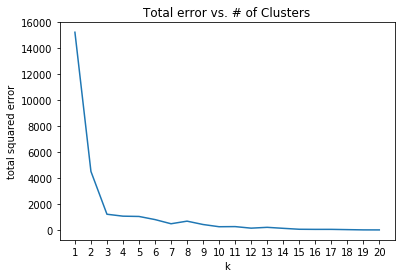

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel('k')
plt.ylabel('total squared error')
plt.title('Total error vs. # of Clusters')

In [104]:
def is_leaf(cluster):
    """A cluster is a leaf if it has length 1."""
    return len(cluster) == 1

In [105]:
def get_children(cluster):
    """Returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster."""
    if is_leaf(cluster):
        raise TypeError('a leaf cluster has no children')
    else:
        return cluster[1]

In [106]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    """Compute all the pairwise distances between cluster1 and cluster2
    and apply _distance_agg_ to the resulting list."""
    return distance_agg([distance(input1, input2)
                         for input1 in get_values(cluster1)
                         for input2 in get_values(cluster2)])

In [113]:
def get_values(cluster):
    """Returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)."""
    if is_leaf(cluster):
        return cluster # Is already a 1-tuple containing value.
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]

In [114]:
def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple.

In [115]:
import math

def bottom_up_cluster(inputs, distance_agg=min):
    # Starts with every input a leaf cluster / 1-tuple.
    clusters = [(input,) for input in inputs]
    
    # As long as we have more than one cluster left...
    while len(clusters) > 1:
        # Find the two closests clusters.
        c1, c2 = min([(cluster1, cluster2) 
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]],
                      key=lambda t: cluster_distance(t[0], t[1], distance_agg))
        
        # Remove them from the list of clusters.
        clusters = [c for c in clusters if c != c1 and c != c2]
        
        # Merge them, using merge_order = # of clusters left.
        merged_cluster = (len(clusters), [c1, c2])
        
        # And add their merge.
        clusters.append(merged_cluster)
    
    # When there's only one cluster left, return it.
    return clusters[0]

In [117]:
base_cluster = bottom_up_cluster(inputs)
base_cluster

(0,
 [(1,
   [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]),
    (16, [([11, 15],), ([13, 13],)])]),
  (2,
   [(4,
     [(5,
       [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]),
      ([-34, -1],)]),
    (6,
     [(7,
       [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]),
        (13,
         [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]),
          ([-18, -3],)])]),
      (12, [([-13, -19],), ([-9, -16],)])])])])

In [118]:
def generate_clusters(base_cluster, num_clusters):
    # Start with a list with just the base cluster.
    clusters = [base_cluster]
    
    # As long as we don't have enough clusters yet.
    while len(clusters) < num_clusters:
        # Choose the last-merged of our clusters.
        next_cluster = min(clusters, key=get_merge_order)
        
        # Remove it from the list.
        clusters = [c for c in clusters if c != next_cluster]
        
        # And add its children to the list (i.e., unmerge it).
        clusters.extend(get_children(next_cluster))
    
    # Once we have enough clusters.
    return clusters

In [120]:
three_clusters = [get_values(cluster) 
                  for cluster in generate_clusters(base_cluster, 3)]
three_clusters

[[[-49, 0],
  [-46, 5],
  [-41, 8],
  [-49, 15],
  [-34, -1],
  [-22, -16],
  [-19, -11],
  [-25, -9],
  [-11, -6],
  [-12, -8],
  [-14, -5],
  [-18, -3],
  [-13, -19],
  [-9, -16]],
 [[19, 28], [21, 27], [20, 23], [26, 13]],
 [[11, 15], [13, 13]]]

Text(0, 0.5, 'blocks north of city center')

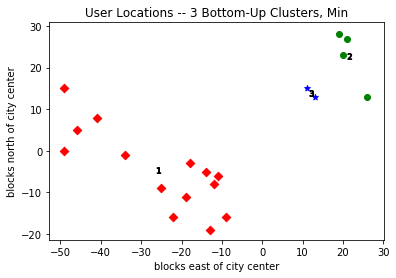

In [123]:
for i, cluster, marker, color in zip([1,2,3],
                                     three_clusters, 
                                     list('Do*'),
                                     list('rgb')):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    
    # Put a number at the mean of the cluster.
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title('User Locations -- 3 Bottom-Up Clusters, Min')
plt.xlabel('blocks east of city center')
plt.ylabel('blocks north of city center')

Text(0, 0.5, 'blocks north of city center')

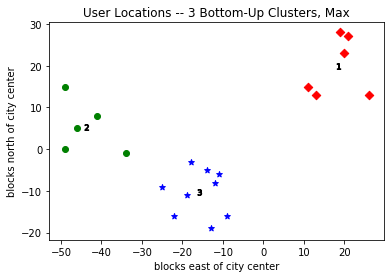

In [124]:
# Using max distance.
base_cluster = bottom_up_cluster(inputs, distance_agg=max)
three_clusters = [get_values(cluster) 
                  for cluster in generate_clusters(base_cluster, 3)]
for i, cluster, marker, color in zip([1,2,3],
                                     three_clusters, 
                                     list('Do*'),
                                     list('rgb')):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    
    # Put a number at the mean of the cluster.
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title('User Locations -- 3 Bottom-Up Clusters, Max')
plt.xlabel('blocks east of city center')
plt.ylabel('blocks north of city center')